In [24]:
import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sb
from numba import jit, njit, int64, float64, boolean
import numba as nb
from numba_i0_i1 import i0, i1
# from numbalsoda import lsoda_sig, lsoda 

import matplotlib.pyplot as plt
plt.rc("axes", labelsize=22)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=22, top=True, direction="out")
plt.rc("ytick", labelsize=22, right=True, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=18)


from joblib import Parallel, delayed
e = 1.602e-19
eps0 = 8.8541878128e-12
u = 1.66e-27
k_B = 1.381e-23 # J/K
Omega = 2*np.pi*305e3

In [2]:
import sys
# sys.path.append('C:\\Users\\au643642\\OneDrive - Aarhus universitet\\Dokumenter\\PhD\\LUNA2 Mass selection tool')
# from mass_selection_functions import popt_all_fit
# xi1, xi0, upper_edge_shrink1, upper_edge_shrink0, lower_edge_shrink1, lower_edge_shrink0 = popt_all_fit[:6]
# from mathieu_functions import upper_mathieu_variable_shrink, lower_mathieu_variable_shrink

def get_z0(r0, mz):
    xi = (xi1*mz + xi0)
    return np.sqrt((xi-r0**2)/2)

def QIT_diagram(RF_V, upper, mz, QIT_r0, QIT_z0):
    xi = (QIT_r0**2 + 2*QIT_z0**2)
    q_to_V = mz*u/e*Omega**2/8 * xi
    if upper:
        return upper_mathieu_variable_shrink(np.atleast_1d(RF_V) / q_to_V, 0, 0, 0, 0)*q_to_V
    return lower_mathieu_variable_shrink(np.atleast_1d(RF_V) / q_to_V, 0, 0, 0, 0)*q_to_V

In [3]:
@njit(nb.types.Tuple((float64[:], float64[:]))(float64, float64, float64))
def find_I0_lns(r0, z0, max_order):
    i = np.arange(max_order+1)
    ln = (2*i+1)*np.pi/2/z0
    res = i0(r0*ln)
    return res, ln
@njit(nb.types.Tuple((float64[:], float64[:]))(float64[:], float64[:], float64[:], float64[:]))
def optimized_besselsum(zs, rs, I0_lns, ln):
    cos_term = np.cos(np.outer(ln, zs))  # Precompute the cos term matrix
    sin_term = np.sin(np.outer(ln, zs))  # Precompute the sin term matrix
    r_ln_matrix = np.outer(ln, rs)
    i0_r_ln_matrix = i0(r_ln_matrix.flatten())
    i1_r_ln_matrix = i1(r_ln_matrix.flatten())
    i0_r_ln_matrix = i0_r_ln_matrix.reshape(r_ln_matrix.shape)
    i1_r_ln_matrix = i1_r_ln_matrix.reshape(r_ln_matrix.shape)
    
    bessel_r_matrix = (-1) ** np.arange(len(ln))[:, np.newaxis]       * i1_r_ln_matrix / I0_lns[:, np.newaxis]
    bessel_z_matrix = (-1) ** (np.arange(len(ln)) + 1)[:, np.newaxis] * i0_r_ln_matrix / I0_lns[:, np.newaxis]
    
    besselsum_r = np.sum(bessel_r_matrix * cos_term, axis=0)
    besselsum_z = np.sum(bessel_z_matrix * sin_term, axis=0)
    
    return besselsum_r, besselsum_z

@njit(float64[:](float64,
     float64[:],
     int64,
     int64,
     int64,
     float64,
     float64,
     float64,
     float64,
     float64[:],
     float64[:],
     int64,
     boolean[:]))
def CIT_EOM_cartesian(t, y, U, V, charge_number, mass, r0, z0, Omega, I0_lns, ln, N_sim, is_not_out_of_bounds):
    q = charge_number*e

    xs = y[:N_sim]
    ys = y[N_sim:2*N_sim]
    rs = np.sqrt(xs**2 + ys**2)

    zs = y[2*N_sim:3*N_sim]
    
    vxs = y[3*N_sim:4*N_sim]
    vys = y[4*N_sim:5*N_sim]
    vzs = y[5*N_sim:]
    

    besselsum_r, besselsum_z = optimized_besselsum(zs, rs, I0_lns, ln)
    t_factor = -2*q/mass/z0 * (U + V*np.cos(Omega*t))

    acc_r = besselsum_r * t_factor
    acc_z = besselsum_z * t_factor

    ret = np.empty_like(y)
    ret[       :  N_sim] = is_not_out_of_bounds * vxs
    ret[  N_sim:2*N_sim] = is_not_out_of_bounds * vys
    ret[2*N_sim:3*N_sim] = is_not_out_of_bounds * vzs

    ret[3*N_sim:4*N_sim] = is_not_out_of_bounds * acc_r * xs / rs
    ret[4*N_sim:5*N_sim] = is_not_out_of_bounds * acc_r * ys / rs
    ret[5*N_sim:       ] = is_not_out_of_bounds * acc_z
    return ret


In [4]:
@njit
def simulate_CIT_no_buffer_gas(U : float, V : float, r0 : float, z0 : float, Omega : float,
                                 mass_amu : int, charge_number : int, N_sim : int, sigma_xyz : float,
                                 T : float, ts):
    mass = mass_amu * u
    mass_gas = 4 * u

    N_order = 10
    I0_lns, ln = find_I0_lns(r0, z0, N_order)
    
    MB_sigma = np.sqrt(k_B*T / mass)
    y0s = np.empty(6*N_sim)
    for i in range(3*N_sim):
        y0s[i]         = np.random.normal(0, sigma_xyz)
        y0s[3*N_sim+i] = np.random.normal(0, MB_sigma)

    y0s[:3*N_sim] = np.clip(y0s[:3*N_sim], -3*sigma_xyz, 3*sigma_xyz)
    y0s[3*N_sim:] = np.clip(y0s[3*N_sim:], -3*MB_sigma, 3*MB_sigma)

    curr_y = y0s
    
    xs = curr_y[:N_sim]
    ys = curr_y[N_sim:2*N_sim]
    zs = curr_y[2*N_sim:3*N_sim]
    vxs = curr_y[3*N_sim:4*N_sim]
    vys = curr_y[4*N_sim:5*N_sim]
    vzs = curr_y[5*N_sim:]

    axs = np.zeros(N_sim)
    ays = np.zeros(N_sim)
    azs = np.zeros(N_sim)

    out_of_bounds = np.logical_or(np.abs(zs) > z0, np.sqrt(xs**2 + ys**2) > r0)
    not_out_of_bounds = np.logical_not(out_of_bounds)
    curr_N = N_sim
    
    n_steps = len(ts)-1
    N_history = np.zeros(n_steps)
    for i in range(n_steps):
        t_start = ts[i]
        t_end = ts[i+1]
        t_step = t_end - t_start

        ## -- Velocity-Verlet
        xs = curr_y[:N_sim]
        ys = curr_y[N_sim:2*N_sim]
        zs = curr_y[2*N_sim:3*N_sim]
        vxs = curr_y[3*N_sim:4*N_sim]
        vys = curr_y[4*N_sim:5*N_sim]
        vzs = curr_y[5*N_sim:]

        # Update positions
        xs += vxs*t_step + 0.5*axs*t_step**2
        ys += vys*t_step + 0.5*ays*t_step**2
        zs += vzs*t_step + 0.5*azs*t_step**2

        # Calculate the acceleration
        dy = CIT_EOM_cartesian(t_start, curr_y, U, V, charge_number, mass, r0, z0, Omega, I0_lns, ln, N_sim, not_out_of_bounds)

        # Update velocities
        curr_y[3*N_sim:4*N_sim] += 0.5 * (axs + dy[3*N_sim:4*N_sim]) * t_step
        curr_y[4*N_sim:5*N_sim] += 0.5 * (ays + dy[4*N_sim:5*N_sim]) * t_step
        curr_y[5*N_sim:]        += 0.5 * (azs + dy[5*N_sim:]       ) * t_step

        # Update accelerations
        axs = dy[3*N_sim:4*N_sim]
        ays = dy[4*N_sim:5*N_sim]
        azs = dy[5*N_sim:]
        ## - END VELOCITY-VERLET

        xs = curr_y[:N_sim]
        ys = curr_y[N_sim:2*N_sim]
        zs = curr_y[2*N_sim:3*N_sim]

        # Check if some of the simulation ions are out of bounds
        out_of_bounds     = np.logical_or(out_of_bounds, np.logical_or(np.abs(zs) > z0, np.sqrt(xs**2 + ys**2) > r0))
        not_out_of_bounds = np.logical_not(out_of_bounds)

        curr_N = np.sum(not_out_of_bounds)
        N_history[i] = curr_N
        if curr_N == 0:
            break

    return curr_N, curr_y, not_out_of_bounds, N_history

In [28]:
mass = 443
charge_number = 1
N_sim = 100

delta_t = 1e-3
ts = np.arange(0, delta_t, 0.1e-6)
r0 = 10e-3
z0 = 9e-3
sigma_xyz = 0.2e-3
T = 300

N, curr_y, not_out_of_bounds, N_history\
   = simulate_CIT_no_buffer_gas(U=0, V=420, r0=r0, z0=z0, Omega = Omega,
                                    mass_amu=mass, charge_number=charge_number, 
                                    N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                    ts=ts)

In [12]:
xs = curr_y[:N_sim][not_out_of_bounds]
ys = curr_y[N_sim:2*N_sim][not_out_of_bounds]
rs = np.sqrt(xs**2 + ys**2)
zs = curr_y[2*N_sim:3*N_sim][not_out_of_bounds]
np.std(rs)*1e3, np.std(zs)*1e3


(0.2005443269472324, 0.3144549561846665)

(0.0, 10.0)

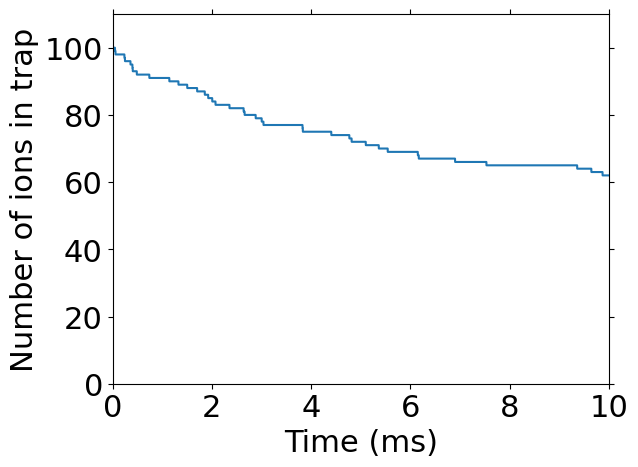

In [13]:
plt.plot(ts[:-1]*1e3, N_history)
plt.xlabel('Time (ms)')
plt.ylabel('Number of ions in trap')
plt.ylim(0, 110)
plt.xlim(0, 10)

In [55]:
VDCs = np.linspace(-50,120,30)
VRFs = np.linspace(250,500,30)
DataGrid = np.zeros((len(VDCs),len(UDCs)))
# for i,VDC in enumerate(VDCs):
#     for j,VRF in enumerate(VRFs):
#         N, curr_y, not_out_of_bounds, N_history\
#         = simulate_CIT_no_buffer_gas(U=VDC, V=VRF, r0=r0, z0=z0, Omega = Omega,
#                                     mass_amu=mass, charge_number=charge_number, 
#                                     N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
#                                     ts=ts)
#         DataGrid[i,j] = N

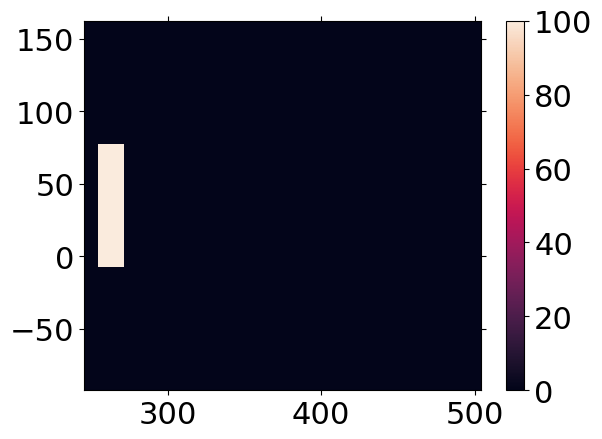

In [47]:
fig,ax = plt.subplots()
heatmap = ax.pcolormesh(UDCs,VDCs,DataGrid, cmap = 'rocket')
fig.colorbar(heatmap)

In [56]:
xi = np.sqrt(2.35e-4)
V = 365.51724137931035
# U_edge_center = QIT_diagram(V, True,  mass, QIT_r0=xi, QIT_z0=0)[0]
delta_U_V = 10


def get_stability(RF):
    mass = 443
    charge_number = 1
    N_sim = 100

    delta_t = 1e-3
    ts = np.arange(0, delta_t, 0.1e-6)
    r0 = 10e-3
    z0 = 9e-3
    sigma_xyz = 0.2e-3
    T = 300
    N_arr = []
    for DC in VDCs:
        N, curr_y, not_out_of_bounds, N_history \
            = simulate_CIT_no_buffer_gas(U=DC, V=RF, r0=r0, z0=z0, Omega = Omega,
                                            mass_amu=mass, charge_number=charge_number, 
                                            N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                            ts=ts)
        N_arr.append(N)
    return N_arr
U_edge_long_sim = Parallel(n_jobs=14, verbose=12)(delayed(get_stability)(RF) for RF in VRFs)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   1 tasks      | elapsed:   30.7s
[Parallel(n_jobs=14)]: Done   2 tasks      | elapsed:   33.0s
[Parallel(n_jobs=14)]: Done   3 tasks      | elapsed:   34.5s
[Parallel(n_jobs=14)]: Done   6 out of  30 | elapsed:   37.4s remaining:  2.5min
[Parallel(n_jobs=14)]: Done   9 out of  30 | elapsed:   51.5s remaining:  2.0min
[Parallel(n_jobs=14)]: Done  12 out of  30 | elapsed:   55.7s remaining:  1.4min
[Parallel(n_jobs=14)]: Done  15 out of  30 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=14)]: Done  18 out of  30 | elapsed:  1.3min remaining:   51.9s
[Parallel(n_jobs=14)]: Done  21 out of  30 | elapsed:  1.5min remaining:   38.0s
[Parallel(n_jobs=14)]: Done  24 out of  30 | elapsed:  1.5min remaining:   22.6s
[Parallel(n_jobs=14)]: Done  27 out of  30 | elapsed:  1.5min remaining:   10.2s
[Parallel(n_jobs=14)]: Done  30 out of  30 | elapsed:  1.7min remaining:    0.0s
[Paralle

In [63]:
# print(U_edge_long_sim)
DATA = np.array(U_edge_long_sim[1])
for line in U_edge_long_sim[1:]:
    DATA = np.vstack((DATA,np.array(line)))
    # print()
print(DATA)


[[  0   0   0   0   0   0  97 100 100 100 100 100 100 100 100   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  97 100 100 100 100 100 100 100 100   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  99 100 100 100 100 100 100 100 100   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 100 100 100 100 100 100 100 100 100  99   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 100 100 100 100 100 100 100 100 100 100   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  63 100 100 100 100 100 100 100 100 100 100   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  97 100 100 100 100 100 100 100 100 100 100 100   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 100 100 100 100 100 100 100 100 100 100 100 100   0
    0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
fig,ax = plt.subplots()
heatmap = ax.pcolormesh(UDCs,VDCs,DataGrid, cmap = 'rocket')
fig.colorbar(heatmap)

In [12]:
np.savez('CIT_edge_5s_single_edge', Ns=U_edge_long_sim, Us=Us)

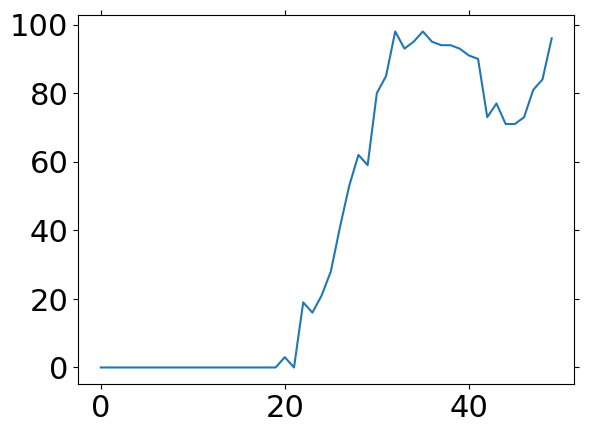

In [13]:
plt.plot(U_edge_long_sim)

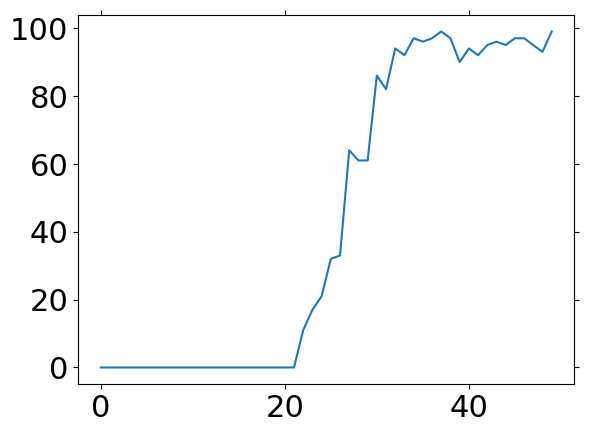

In [13]:
plt.plot(U_edge_long_sim)

In [8]:
def simulate_signal(V, r0, z0, Omega, mass, charge_number, N_sim, ts):
    xi = np.sqrt(2.35e-4)
    edge_upper = QIT_diagram(V, True,  mass, QIT_r0=xi, QIT_z0=0)[0]
    edge_lower = QIT_diagram(V, False, mass, QIT_r0=xi, QIT_z0=0)[0]
    delta_U_V = 10
    U_edge_steps = 20
    Us = np.empty(U_edge_steps*2)
    if edge_lower - edge_upper < delta_U_V*2:
        Us = np.linspace(edge_upper - delta_U_V, edge_lower + delta_U_V, U_edge_steps*2)
    else: 
        Us = np.concatenate((np.linspace(edge_upper-delta_U_V, edge_upper+delta_U_V),
                            np.linspace(edge_lower-delta_U_V, edge_lower+delta_U_V)))
    Ns = []
    N_histories = []
    for U in Us:
        N, curr_y, not_out_of_bounds, N_history \
        = simulate_CIT_no_buffer_gas(U=U, V=V, r0=r0, z0=z0, Omega = Omega,
                                        mass_amu=mass, charge_number=charge_number, 
                                        N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                        ts=ts)
        Ns.append(N)
        N_histories.append(N_history)
    return np.array(Ns), Us, np.array(N_histories)

In [10]:
N_sim = 100

Vs = np.linspace(200, 500, 30)
               
delta_t = 10e-3
ts = np.arange(0, delta_t, 0.1e-6)

Ns, Us, N_histories = zip(*Parallel(n_jobs=10, verbose=12)(delayed(simulate_signal)(V, r0, z0, Omega, mass, charge_number, N_sim, ts) for V in Vs))
Ns = np.array(Ns)
Us = np.array(Us)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed: 24.8min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed: 25.1min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed: 25.2min
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed: 25.3min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed: 25.4min
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed: 25.8min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed: 25.8min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed: 26.1min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed: 26.3min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed: 26.5min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed: 49.2min
[Parallel(n_jobs=10)]: Done  14 out of  30 | elapsed: 50.0min remaining: 57.2min
[Parallel(n_jobs=10)]: Done  17 out of  30 | elapsed: 52.0min remaining: 39.8min
[Parallel(n_jobs=10)]: Done  20 out of  30 | elapsed: 54.0min remaining: 27.0mi

In [11]:
np.savez('../Final simulations mz 415/CIT_edge_no_gas_10ms_100ns_100K_0.25mm_100_ions', Vs=Vs, Us=Us, Ns=Ns, N_histories=N_histories, allow_pickle=True)

In [5]:
load_file = np.load('CIT_edge_no_gas_10ms_100ns_100K_0.25mm.npz')
load_Vs = load_file['Vs']
load_Us = load_file['Us']
load_Ns = load_file['Ns']

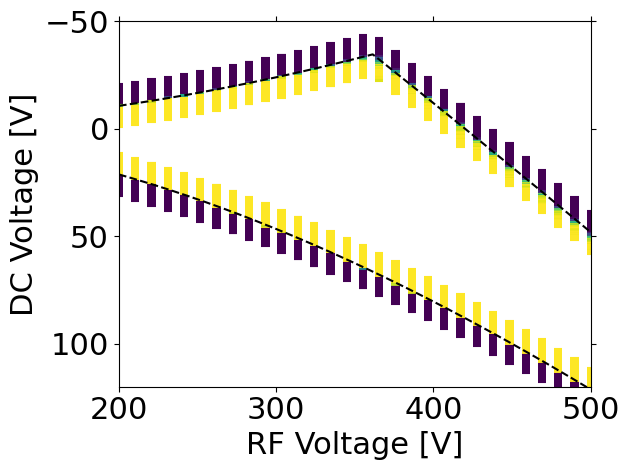

In [6]:
for V, U, N in zip(load_Vs, load_Us, load_Ns):
    n = len(N)
    plt.scatter(V*np.ones(n), U, c=N, marker='_')
mass = 414
linspace_Vs = np.linspace(load_Vs[0], load_Vs[-1], 1000)
xi = np.sqrt(2.35e-4)
plt.plot(linspace_Vs, QIT_diagram(linspace_Vs, True,  mass, QIT_r0=xi, QIT_z0=0), 'k--')
plt.plot(linspace_Vs, QIT_diagram(linspace_Vs, False, mass, QIT_r0=xi, QIT_z0=0), 'k--')

plt.xlim(200, 500)
plt.ylim(120, -50)
plt.xlabel('RF Voltage [V]')
plt.ylabel('DC Voltage [V]')
plt.tight_layout()

In [6]:
from scipy.special import erf
from scipy.optimize import curve_fit
def edge_function(x, center, width, A):
    return A*(1-erf((x-np.abs(center))/(width)))/2

RF V:  365.51724137931035
[31.61359502  2.02507012  0.9895048 ]


Text(0, 0.5, 'Ion signal')

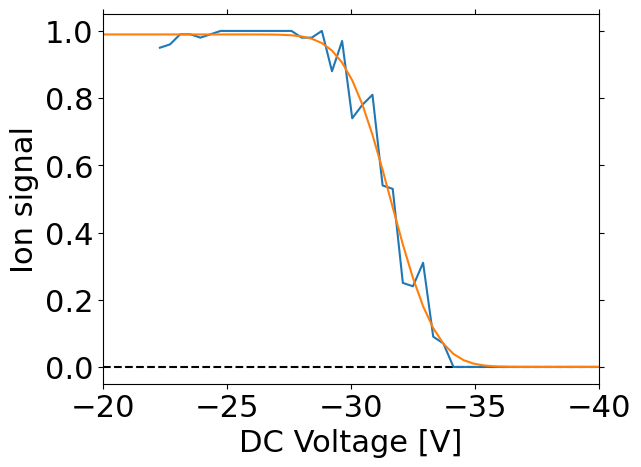

In [8]:
plt.hlines(0, -20, -40, colors='k', ls='--')
i = 16
print('RF V: ', load_Vs[i])
idxs = load_Us[i] < 0
plt.plot(load_Us[i][idxs], load_Ns[i][idxs]/100)


popt, _ = curve_fit(edge_function, -load_Us[i][idxs], load_Ns[i][idxs]/100, p0=(30, 10, 1))
print(popt)
plt.plot(load_Us[i], edge_function(-load_Us[i], *popt))

plt.xlim(-20, -40)
plt.ylim(-0.05, 1.05)

plt.xlabel('DC Voltage [V]')
plt.ylabel('Ion signal')